In [1]:
import os
import pandas as pd
import json
import matplotlib
import torch
from tqdm.notebook import tqdm

In [2]:
%run ../utils/__init__.py
%run ../metrics/__init__.py

In [3]:
%run ../utils/plots.py

In [4]:
matplotlib.rcParams['figure.facecolor'] = 'white'

In [5]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

## Load data

In [6]:
%run ../datasets/__init__.py

In [90]:
dataset_kwargs = {
    'dataset_name': 'covid-uc',
    'max_samples': None,
    'frontal_only': False,
    'image_size': (512, 512),
}
dataloader = prepare_data_classification(dataset_type='all', **dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

Loading covid-uc/all dataset...


883

## Load model

In [122]:
%run ../models/checkpoint/__init__.py

In [123]:
run_name = '0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid'
debug = False

In [124]:
compiled_model = load_compiled_model_classification(run_name, debug, DEVICE)
compiled_model.metadata

FOUND:  20 checkpoint_20.pt [(16, 'checkpoint_16.pt'), (2, 'checkpoint_2.pt'), (-1, 'metadata.json'), (3, 'checkpoint_3.pt'), (13, 'checkpoint_13.pt'), (19, 'checkpoint_19.pt'), (20, 'checkpoint_20.pt')]


{'model_kwargs': {'model_name': 'densenet-121',
  'labels': ['covid', 'pneumonia', 'normal'],
  'imagenet': True,
  'freeze': False,
  'image_size': [512, 512]},
 'opt_kwargs': {'lr': 1e-06},
 'hparams': {'loss_name': 'cross-entropy',
  'loss_kwargs': {},
  'batch_size': 28},
 'dataset_kwargs': {'dataset_name': 'covid-x',
  'labels': None,
  'max_samples': None,
  'batch_size': 28,
  'image_size': [512, 512]},
 'dataset_train_kwargs': {'oversample': True,
  'oversample_label': 'covid',
  'oversample_max_ratio': None,
  'augment': True,
  'augment_label': 'covid',
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.5,
   'brightness': 0.5},
  'undersample': False,
  'undersample_label': None}}

In [11]:
model = compiled_model.model
_ = model.eval()

## Run through data

In [32]:
from torch.nn.functional import softmax

In [102]:
from collections import defaultdict

In [12]:
LABELS = dataloader.dataset.labels
LABELS

['covid', 'Non-COVID', 'normal']

In [98]:
COVID_IDX = 0

In [110]:
debugging = defaultdict(lambda: list())

def get_predictions(model, dataloader, covid_threshold=None):
    torch.set_grad_enabled(False)

    labels = dataloader.dataset.labels
    cm_predictions = [[[] for _ in range(len(labels))] for _ in range(len(labels))]

    for batch in tqdm(dataloader):
        images, labels = batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        outputs = outputs[0].detach()

        for gt, prediction in zip(labels, outputs):
            gt = int(gt.item())
            label_predicted = prediction.argmax().item()
            
            # NOTE: forcing threshold on COVID
            if covid_threshold and label_predicted == COVID_IDX:
                probas = softmax(prediction, dim=-1)
                under_threshold = probas.max().item() < covid_threshold
                if under_threshold:
                    # Use next best thing
                    predictions_copy = prediction.clone()
                    predictions_copy[COVID_IDX] = prediction.min().item() - 10
                    label_predicted = predictions_copy.argmax().item()
#                 else:
#                     predictions_copy = None # DEBUG
                    
#                 debugging['threshold'].append((prediction,
#                                                probas,
#                                                under_threshold,
#                                                predictions_copy,
#                                                label_predicted))

            cm_predictions[gt][label_predicted].append(prediction.cpu())
            
    cm = [[len(l) for l in row] for row in cm_predictions]
    
    return cm_predictions, cm

In [79]:
def plot_distribution(cm_preds, gt_chosen=2, pred_chosen=0, **kwargs):
    predictions = cm_preds[gt_chosen][pred_chosen]
    selection = f'GT: {LABELS[gt_chosen]}, Pred: {LABELS[pred_chosen]}'
    if len(predictions) == 0:
        print(f'No predictions match! ({selection})')
        return
    predictions = torch.stack(predictions)
    # shape: n_cases, n_labels
    
    probas_predicted = softmax(predictions, dim=-1)[:, pred_chosen]
    # shape: n_cases
    
    plt.hist(probas_predicted, **kwargs)
    plt.xlabel(f'Prediction probability of class {LABELS[pred_chosen]}')
    plt.ylabel('Sample count')
    plt.title(f'{selection} ({len(predictions)} cases)')

In [119]:
cm_preds, cm = get_predictions(model, dataloader, covid_threshold=0.6)

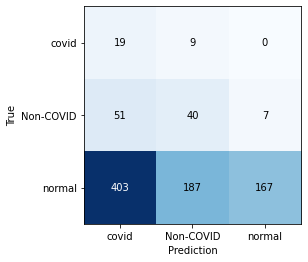

In [120]:
plot_cm(cm, LABELS)

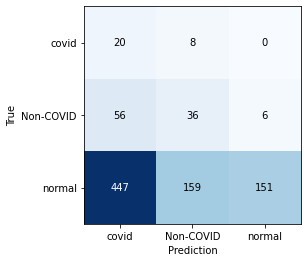

In [60]:
plot_cm(cm, LABELS)

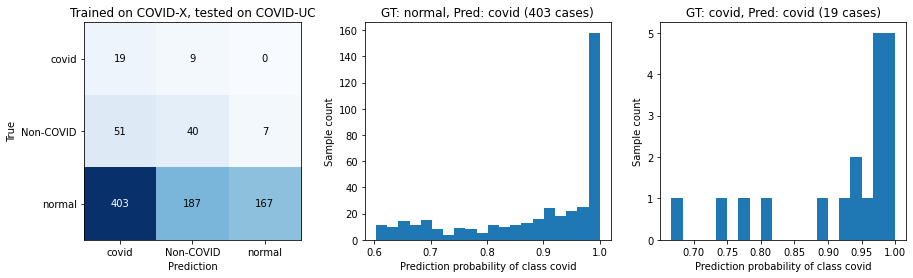

In [121]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_cm(cm, LABELS, title='Trained on COVID-X, tested on COVID-UC')

plt.subplot(1, 3, 2)
plot_distribution(cm_preds, 2, 0, bins=20)

plt.subplot(1, 3, 3)
plot_distribution(cm_preds, 0, 0, bins=20)

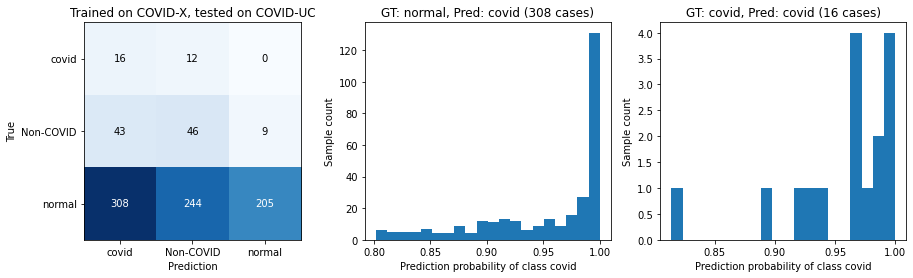

In [118]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_cm(cm, LABELS, title='Trained on COVID-X, tested on COVID-UC')

plt.subplot(1, 3, 2)
plot_distribution(cm_preds, 2, 0, bins=20)

plt.subplot(1, 3, 3)
plot_distribution(cm_preds, 0, 0, bins=20)